# Response Matrix Testing

In this notebook, I'm testing out the ability to construct a response matrix for MOXSI

In [1]:
import numpy as np
import distributed
from scipy.interpolate import interp1d
import astropy.units as u
import astropy.wcs
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from sunpy.coordinates import Helioprojective, get_earth
import sunpy.map
from astropy.wcs.utils import pixel_to_pixel
from astropy.visualization import ImageNormalize, AsymmetricPercentileInterval, LogStretch
import ndcube

from synthesizAR.atomic.idl import spectrum_to_cube

from mocksipipeline.physics.spectral import SpectralModel
from mocksipipeline.detector.response import SpectrogramChannel, get_all_dispersed_channels
from overlappy.util import color_lat_lon_axes

## Theory

From CHIANTI, we can produce spectral map of the radiative loss as a function of $\lambda$ and $T$,

$$
S(\lambda,T)\quad[\mathrm{ph}\,\mathrm{cm}^3\,\mathrm{s}^{-1}\,\mathrm{sr}^{-1}\,\mathrm{Å}^{-1}]
$$

Additionally, the instrument response is a function of $\lambda$ and $m$ (spectral order),

$$
\varepsilon(\lambda, m)\quad[\mathrm{cm}^2\,\mathrm{sr}\,\mathrm{pix}^{-1}\,\mathrm{DN}\,\mathrm{ph}^{-1}\mathrm{Å}]
$$

Combining these two gives us our intermediate response matrix,

$$
R^\prime(\lambda,m,T) = S(\lambda, T)\varepsilon(\lambda,m)\quad[\mathrm{DN}\,\mathrm{cm}^{5}\,\mathrm{s}^{-1}\,\mathrm{pix}^{-1}]
$$

We then want to understand how to include our mapping from world pixel to detector pixel.
Ultimately, we want a 3D response matrix which depends on $p^\prime,p,T$, the pixel coordinate in the inverted frame, the pixel coordinate in the original detector, and the temperature, respectively,

$$
R(p^\prime,p,T)\quad[\mathrm{DN}\,\mathrm{cm}^{5}\,\mathrm{s}^{-1}\,\mathrm{pix}^{-1}]
$$

## Outline of Steps

The steps for doing this are:

1. Compute $R^\prime$
2. Create a WCS with equivalent scale, roll angle, reference coordinate but that is limited to the FOV of the instrument
3. Create WCS for each spectral order $m$
4. For the direction of the primed WCS that aligns with the dispersion, create an array that spans the every pixel in that direction (this is probably a whole row).
5. For every combination of $(p^\prime,\lambda, m)$, compute $p$
6. Map $R^\prime$ into $R$ for each $\lambda,m,p^\prime$

## Step 1: Spectra and Instrument Response

In [2]:
spec_table = SpectralModel().spectral_table

(0.0, 1634.5454545454545)

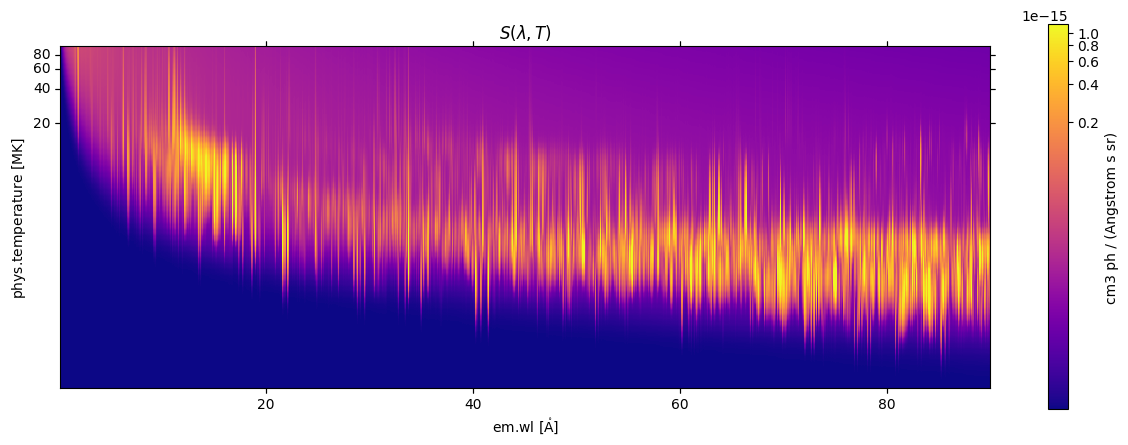

In [3]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(projection=spec_table.wcs)
vmin, vmax = AsymmetricPercentileInterval(1,98).get_limits(spec_table.data)
spec_table.plot(axes=ax,
                aspect=10,
                axes_units=('MK','Angstrom'),
                norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()),
                cmap='plasma')
fig.colorbar(ax.get_images()[0], label=spec_table.unit)
ax.set_title(r'$S(\lambda, T)$')
ax.set_xlim(spec_table.wcs.world_to_pixel([0.1,90]*u.Angstrom,0*u.MK)[0])

In [4]:
all_channels = get_all_dispersed_channels()

In [5]:
def compute_r_prime(spectra, channel):
    f_interp = interp1d(spectra.axis_world_coords(1)[0].to_value('Angstrom'),
                        spectra.data,
                        axis=1,
                        bounds_error=False,
                        fill_value=0.0,)  # Response is 0 outside of the response range
    spectra_interp = f_interp(channel.wavelength.to_value('Angstrom')) * spectra.unit
    response = channel.wavelength_response * channel.plate_scale * (channel.spectral_resolution*u.pix)
    r_prime = spectra_interp * response
    return spectrum_to_cube(r_prime, channel.wavelength, spectra.axis_world_coords(0)[0],)

In [6]:
r_prime = [compute_r_prime(spec_table, chan) for chan in all_channels]

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


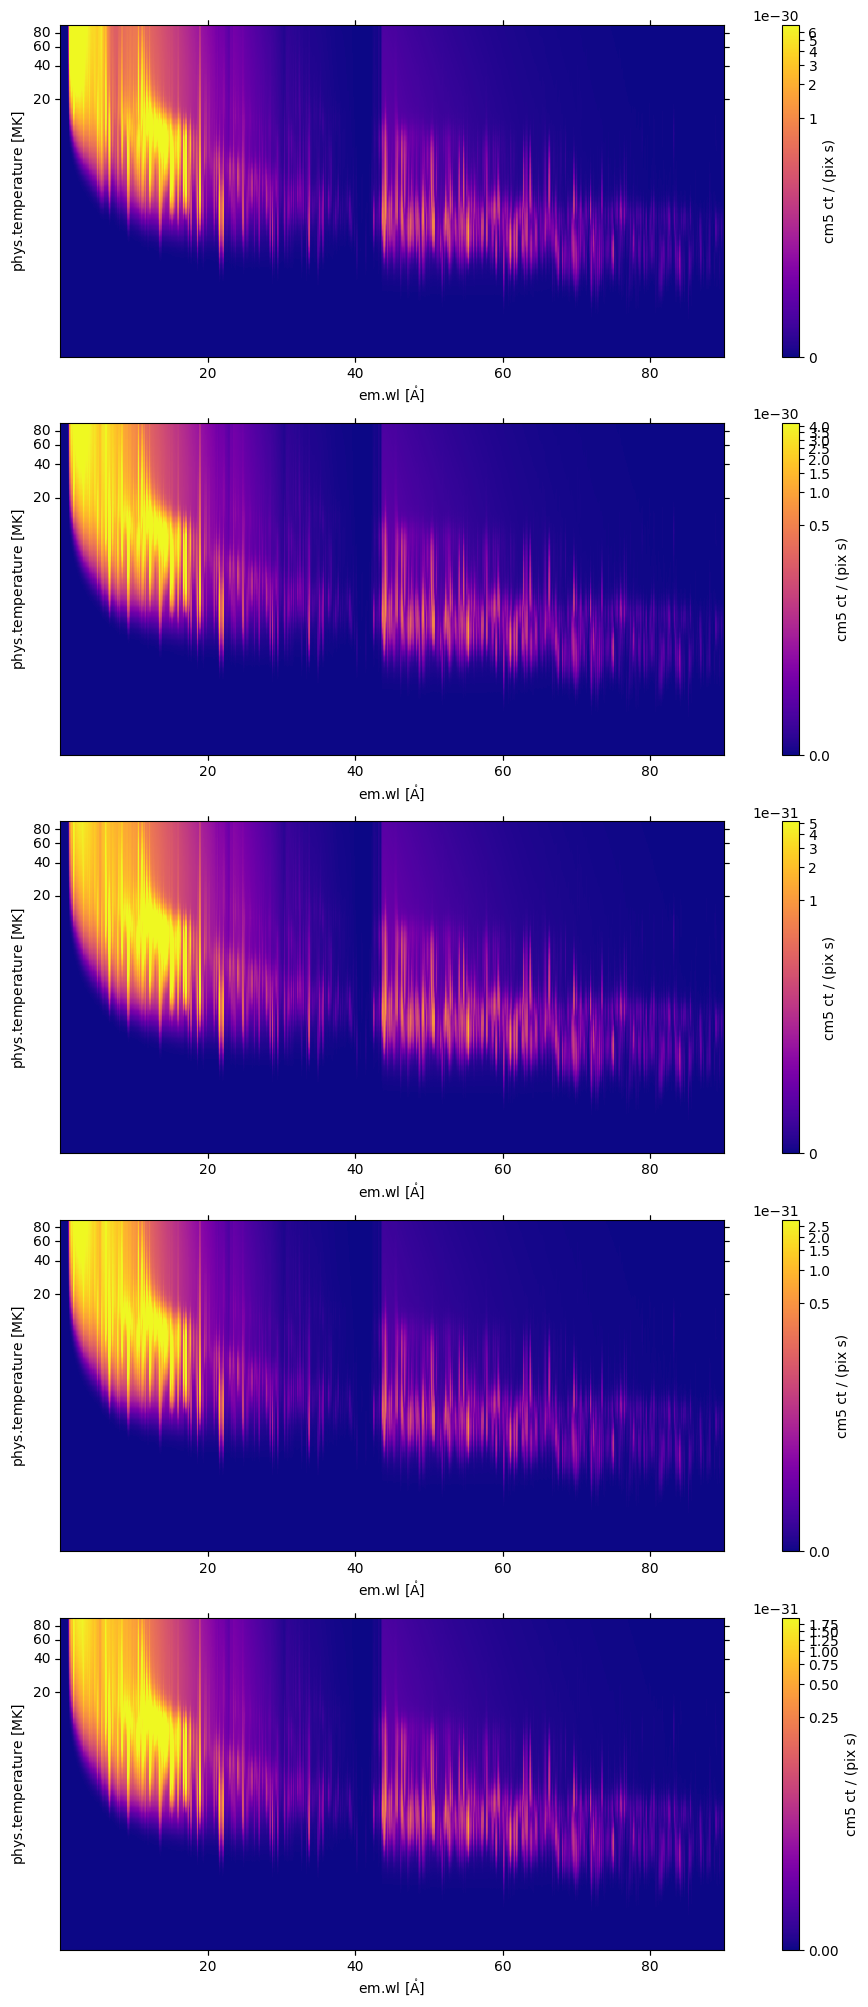

In [7]:
fig = plt.figure(figsize=(15,5*5))
for i,rp in enumerate(r_prime[4:]):
    ax = fig.add_subplot(5,1,i+1,projection=rp.wcs)
    vmin, vmax = AsymmetricPercentileInterval(1,99).get_limits(rp.data)
    aspect_ratio = rp.axis_world_coords(1)[0].shape[0] / rp.axis_world_coords(0)[0].shape[0]
    rp.plot(axes=ax,
            aspect=0.5*aspect_ratio,
            axes_units=('MK','Angstrom'),
            norm=ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch()),
            cmap='plasma')
    fig.colorbar(ax.get_images()[0], label=rp.unit)
    #ax.set_title(f'$R^\prime(\lambda, m={order}, T)$')
#ax.set_xlim(r_prime[f'{order}'].wcs.world_to_pixel([0.1,70]*u.Angstrom,0*u.MK)[0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '$R^\\prime(\\lambda,m,T=7.94 MK)$')

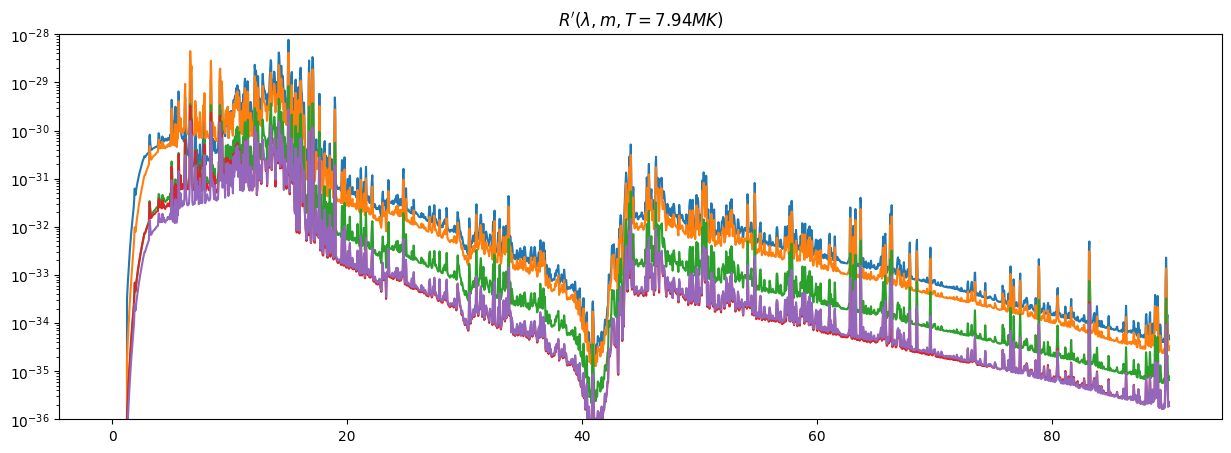

In [8]:
fig = plt.figure(figsize=(15,5))
t_index = 38
t_val = r_prime[0].axis_world_coords(0)[0][t_index].to('MK')
ax = fig.add_subplot()
for rp in r_prime[4:]:
    ax.plot(rp.axis_world_coords(1)[0], rp[t_index, :].data)
ax.set_yscale('log')
ax.set_ylim(1e-36, 1e-28)
ax.legend(frameon=False)
ax.set_title(f'$R^\prime(\lambda,m,T={t_val:.2f})$')

## Step 2: Create primed WCS

In [9]:
observer = get_earth('2020-11-09 18:00:00')
hpc_frame = Helioprojective(observer=observer, obstime=observer.obstime)
roll_angle = 0 * u.deg

In [10]:
header = sunpy.map.make_fitswcs_header(
    (450, 450),
    SkyCoord(0, 0, unit='arcsec',frame=hpc_frame),
    scale=all_channels[0].resolution,
    rotation_angle=roll_angle,
)
wcs_prime = astropy.wcs.WCS(header=header)

In [11]:
wcs_prime

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 0.0  0.0  
CRPIX : 225.5  225.5  
PC1_1 PC1_2  : 1.0  -0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.0020555555555555557  0.0020555555555555557  
NAXIS : 450  450

## Step 3: Create dispersed WCS

In [12]:
wcs_dispersed = [chan.get_wcs(observer, roll_angle=roll_angle) for chan in all_channels]

  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]


## Step 4: Create primed pixel coordinates

In [13]:
px_prime = np.arange(wcs_prime.array_shape[1])
py_prime = (wcs_prime.array_shape[0] - 1)/2

In [14]:
coord_prime = wcs_prime.pixel_to_world(px_prime, py_prime)

In [15]:
m_prime = sunpy.map.Map(np.nan*np.ones(wcs_prime.array_shape), wcs_prime)

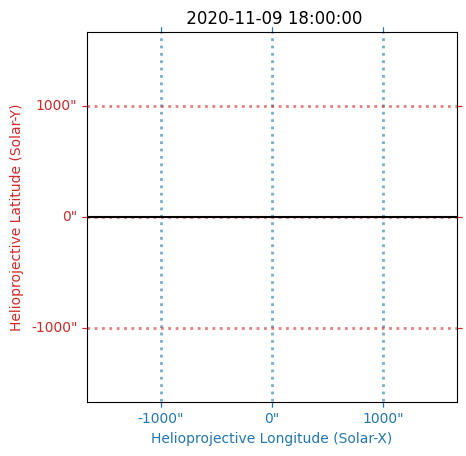

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_prime)
m_prime.plot(axes=ax,cmap='viridis')
color_lat_lon_axes(ax)
ax.plot_coord(coord_prime,color='k')
ax.coords['hpln'].grid(lw=2)
ax.coords['hplt'].grid(lw=2)

## Step 5: Map primed coordinates to dispersed coordinates

In [101]:
response_matrix = np.zeros(wcs_prime.array_shape[1:]+wcs_dispersed[0].array_shape[2:]+r_prime['0'].data.shape[:1])
for order in all_channels:
    for iw, w in enumerate(all_channels[order].wavelength):
        _, _, ix = wcs_dispersed[order].world_to_array_index(coord_prime, w)
        ix = np.array(ix)
        in_bounds = np.where(np.logical_and(ix>=0, ix<response_matrix.shape[1]))
        response_matrix[px_prime[in_bounds], ix[in_bounds], :] += r_prime[f'{order}'].data[:, iw]

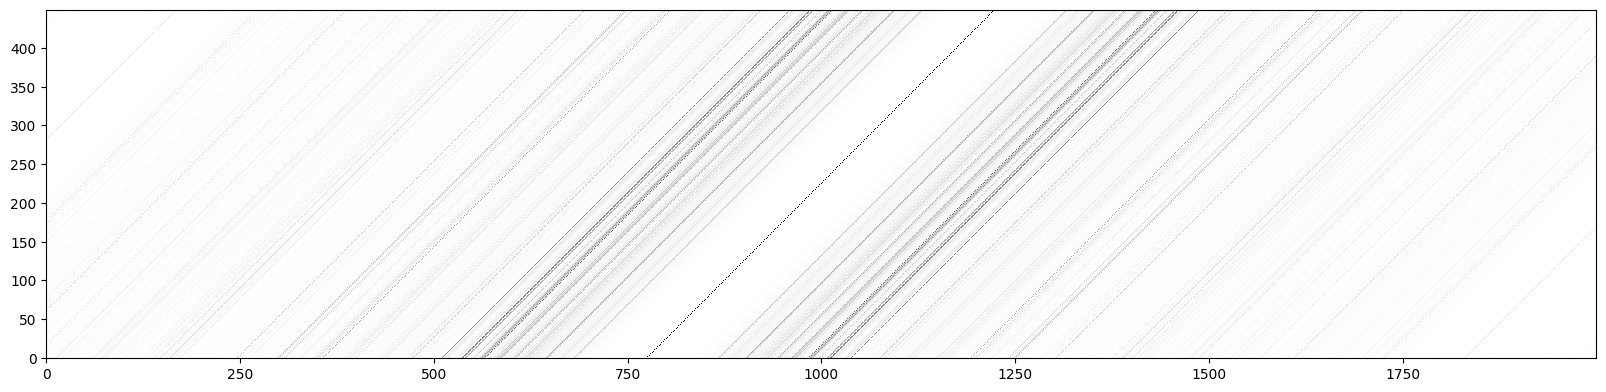

In [103]:
plt.figure(figsize=(20,5))
plt.imshow(response_matrix[...,30], origin='lower', interpolation='none', cmap='Greys', norm=ImageNormalize(stretch=LogStretch()))

In [108]:
r_prime['0'].axis_world_coords(0)[0][25].to('MK')

<Quantity 1.77827941 MK>

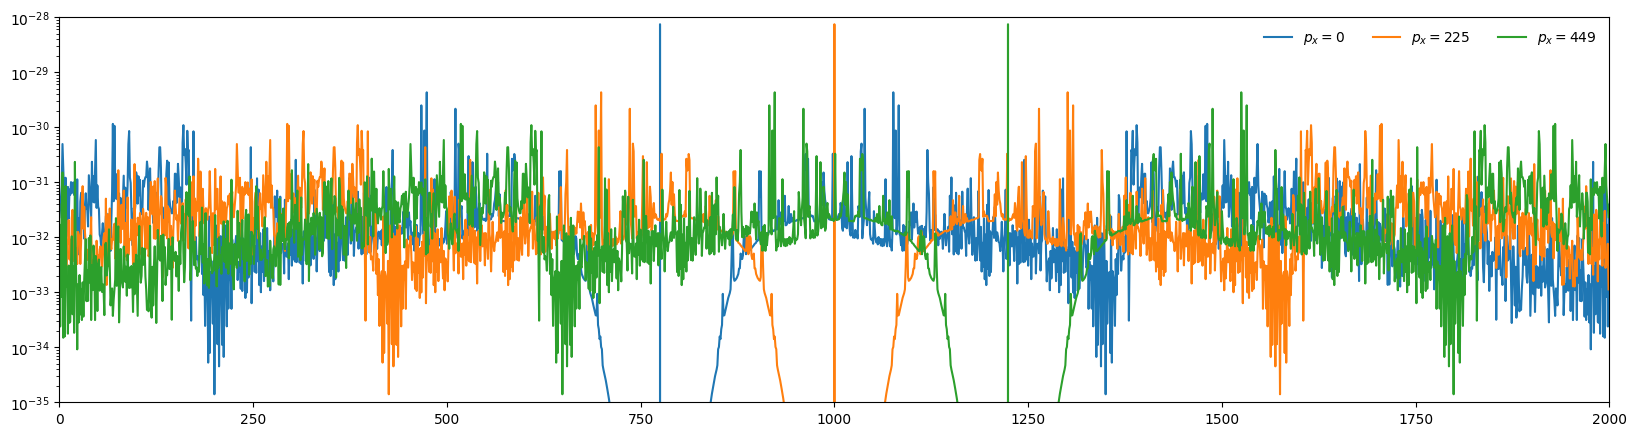

In [132]:
plt.figure(figsize=(20,5))
for i_pos in [0, 225, 449]:
    plt.plot(response_matrix[i_pos,:,25], label=f'$p_x={px_prime[i_pos]}$')
plt.yscale('log')
plt.ylim(1e-35, 1e-28)
plt.xlim(0,2000)
plt.legend(ncol=4,frameon=False)

In [166]:
all_channels[0].reference_pixel

<Quantity [999.5, 374.5,   0. ] pix>

## Debugging

trying to track down a fun bug in the cleaned up response matrix code

In [34]:
dispersed_channels = get_all_dispersed_channels()

In [35]:
extent = 2500 * u.arcsec
shape = tuple(np.ceil((extent / dispersed_channels[0].resolution[::-1]).to_value('pix')).astype(int))

In [49]:
roll_angle = 0 * u.deg
observer = get_earth('2000-01-01 00:00:00')
hpc_frame = Helioprojective(observer=observer, obstime=observer.obstime)
reference_coordinate = SkyCoord(0, 0, unit='arcsec', frame=hpc_frame)
header = sunpy.map.make_fitswcs_header(shape,
                                       reference_coordinate,
                                       reference_pixel=(np.array(shape[::-1]) - 1)/2*u.pix, #dispersed_channels[0].reference_pixel[:2],
                                       scale=dispersed_channels[0].resolution,
                                       rotation_angle=roll_angle)
wcs_prime = astropy.wcs.WCS(header=header)

In [50]:
wcs_dispersed = [chan.get_wcs(observer, roll_angle=roll_angle, dispersion_angle=0*u.deg) for chan in dispersed_channels]

  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]


In [51]:
px_prime = np.arange(wcs_prime.array_shape[1])  # NOTE: assume dispersive axis along the x-axis, gamma=0
py_prime = (wcs_prime.array_shape[0] - 1)/2
coord_prime = wcs_prime.pixel_to_world(px_prime, py_prime)

In [53]:
coord_prime

<SkyCoord (Helioprojective: obstime=2000-01-01T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2000-01-01T00:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -2.95510448, 1.47104358e+11)>): (Tx, Ty) in arcsec
    [(-1246.88481154, 1.24007983e-11), (-1239.48508035, 1.24021604e-11),
     (-1232.08534597, 1.24035224e-11), (-1224.68560842, 1.24048843e-11),
     (-1217.28586772, 1.24062463e-11), (-1209.88612388, 1.24076083e-11),
     (-1202.48637693, 1.24089702e-11), (-1195.08662689, 1.24103321e-11),
     (-1187.68687377, 1.24116940e-11), (-1180.28711759, 1.24130559e-11),
     (-1172.88735837, 1.24144178e-11), (-1165.48759614, 1.24157797e-11),
     (-1158.0878309 , 1.24171415e-11), (-1150.68806268, 1.24185033e-11),
     (-1143.2882915 , 1.24198651e-11), (-1135.88851738, 1.24212269e-11),
     (-1128.48874034, 1.24225887e-11), (-1121.08896039, 1.24239505e-11),
     (-1113.68917755, 1.24253122e-11), (-1106.28939185, 1.24266740e-11)

In [52]:
px_prime

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [58]:
i_pix = wcs_dispersed[5].world_to_array_index(coord_prime, dispersed_channels[5].wavelength[1000])[2]

In [59]:
i_pix

[1331,
 1332,
 1333,
 1334,
 1335,
 1336,
 1337,
 1338,
 1339,
 1340,
 1341,
 1342,
 1343,
 1344,
 1345,
 1346,
 1347,
 1348,
 1349,
 1350,
 1351,
 1352,
 1353,
 1354,
 1355,
 1356,
 1357,
 1358,
 1359,
 1360,
 1361,
 1362,
 1363,
 1364,
 1365,
 1366,
 1367,
 1368,
 1369,
 1370,
 1371,
 1372,
 1373,
 1374,
 1375,
 1376,
 1377,
 1378,
 1379,
 1380,
 1381,
 1382,
 1383,
 1384,
 1385,
 1386,
 1387,
 1388,
 1389,
 1390,
 1391,
 1392,
 1393,
 1394,
 1395,
 1396,
 1397,
 1398,
 1399,
 1400,
 1401,
 1402,
 1403,
 1404,
 1405,
 1406,
 1407,
 1408,
 1409,
 1410,
 1411,
 1412,
 1413,
 1414,
 1415,
 1416,
 1417,
 1418,
 1419,
 1420,
 1421,
 1422,
 1423,
 1424,
 1425,
 1426,
 1427,
 1428,
 1429,
 1430,
 1431,
 1432,
 1433,
 1434,
 1435,
 1436,
 1437,
 1438,
 1439,
 1440,
 1441,
 1442,
 1443,
 1444,
 1445,
 1446,
 1447,
 1448,
 1449,
 1450,
 1451,
 1452,
 1453,
 1454,
 1455,
 1456,
 1457,
 1458,
 1459,
 1460,
 1461,
 1462,
 1463,
 1464,
 1465,
 1466,
 1467,
 1468,
 1469,
 1470,
 1471,
 1472,
 1473,

In [33]:
wcs_dispersed[5]

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 1000.5  375.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  -1.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.0020555555555555557  0.0020555555555555557  7.1800000000000005e-12  
NAXIS : 2000  1500  1254

In [40]:
coord_prime

<SkyCoord (Helioprojective: obstime=2000-01-01T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2000-01-01T00:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -2.95510448, 1.47104358e+11)>): (Tx, Ty) in arcsec
    [(-7393.13235023, -1523.39319565), (-7385.74184355, -1523.39515187),
     (-7378.35131791, -1523.39710614), (-7370.96077331, -1523.39905846),
     (-7363.57020978, -1523.40100882), (-7356.17962733, -1523.40295724),
     (-7348.78902599, -1523.40490371), (-7341.39840576, -1523.40684822),
     (-7334.00776668, -1523.40879079), (-7326.61710877, -1523.4107314 ),
     (-7319.22643203, -1523.41267006), (-7311.83573648, -1523.41460678),
     (-7304.44502216, -1523.41654154), (-7297.05428907, -1523.41847435),
     (-7289.66353724, -1523.42040521), (-7282.27276668, -1523.42233412),
     (-7274.88197741, -1523.42426107), (-7267.49116946, -1523.42618608),
     (-7260.10034283, -1523.42810914), (-7252.70949756, -1523.43003024)

In [41]:
wcs_prime

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 0.0  0.0  
CRPIX : 1000.5  375.5  
PC1_1 PC1_2  : 1.0  -0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.0020555555555555557  0.0020555555555555557  
NAXIS : 338  338

In [42]:
shape

(338, 338)